In [61]:
from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_prediction, stimulation_order, stimulation_palette, plot_ppc, summarize_ppc
import seaborn as sns
import arviz as az
import os.path as op
import pandas as pd
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np
import numpy as np
from bauer.models import FlexibleNoiseRiskRegressionModel
from tqdm import tqdm

bids_folder = '/data/ds-tmsrisk'

# Some convenience functions
def get_info(model_label, bids_folder='/data/ds-tmsrisk'):

    df = get_data(model_label=model_label, bids_folder=bids_folder)
    model = build_model(df=df, model_label=model_label)
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

    return df, model, idata

# Flexible 2

In [77]:
conditions = pd.DataFrame([{'stimulation_condition':'vertex'},
                            {'stimulation_condition':'ips'}])

model_label = 'flexible2'
df, model, idata = get_info(model_label)

df['average_n'] = (df['n_safe'] + df['n_risky']) / 2.
df['average_n_bin3'] = df.groupby('subject')['average_n'].transform(lambda x: pd.qcut(x, 3, labels=['low', 'medium', 'high']))
df['average_n_bin2'] = df.groupby('subject')['average_n'].transform(lambda x: pd.qcut(x, 2, labels=['low', 'high']))


df['bin3(risky/safe)'] = df.groupby(['subject']).apply(lambda x: pd.qcut(x['frac'], 3, labels=['low', 'medium', 'high'])).droplevel(0)
df['bin4(risky/safe)'] = df.groupby(['subject']).apply(lambda x: pd.qcut(x['frac'], 4, labels=['low', 'medium', 'high', 'very high'])).droplevel(0)

model.build_estimation_model(save_p_choice=True)
ppc =model.ppc(df, idata.sel(draw=slice(None, None, 10)), var_names=['p', 'll_bernoulli'])

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]


# for plot in [5,6,7, 8, 9]:
#     g = plot_ppc(df, ppc, plot_type=plot, level='group') 
#     g.fig.suptitle(f'{model_label} - {plot}', y=1.05)

#     g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'cogmodels', f'{model_label}_plot{plot}.pdf'))


Output()

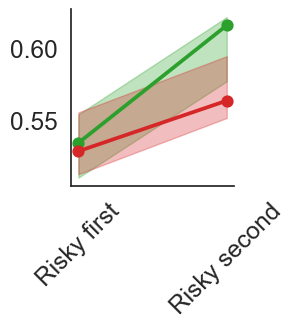

In [78]:
summary = summarize_ppc(ppc.loc['ll_bernoulli'].groupby(['subject', 'stimulation_condition', 'risky_first']).mean(), groupby=['stimulation_condition', 'risky_first'])
p_behavior = df.groupby(['subject', 'stimulation_condition', 'risky_first'])['chose_risky'].mean().groupby(['stimulation_condition', 'risky_first']).mean()

summary = summary.join(p_behavior)

summary['Order'] = summary.index.get_level_values('risky_first').map({True:'Risky first', False:'Risky second'})


g = sns.FacetGrid(summary.reset_index(), hue='stimulation_condition', aspect=1.25, palette=stimulation_palette, height=3)
g.map(sns.pointplot, 'Order', 'chose_risky', order=['Risky first', 'Risky second'])
# g.map(sns.scatterplot, 'Order', 'p_predicted', marker='+', )

g.map(plt.fill_between, 'Order', 'hdi025', 'hdi975', alpha=0.3)

g.set(xlabel=None, ylabel=None,)

# Rotate x-labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_18832/3543192174.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = summarize_ppc(ppc.loc['p'].groupby(['subject'] + groupby).mean(), groupby=groupby)
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppc = ppc.groupby(groupby).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_18832/3543192174.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

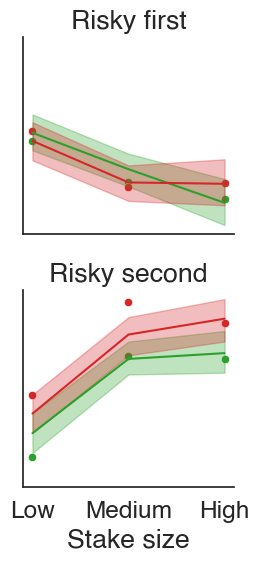

In [64]:
sns.set(style='white', font_scale=1.6, font='Helvetica')
groupby = ['stimulation_condition', 'risky_first', 'average_n_bin3']

summary = summarize_ppc(ppc.loc['p'].groupby(['subject'] + groupby).mean(), groupby=groupby)
p_behavior = df.groupby(['subject'] + groupby)['chose_risky'].mean().groupby(groupby).mean()

summary = summary.join(p_behavior)
summary['Order'] = summary.index.get_level_values('risky_first').map({True:'Risky first', False:'Risky second'})

g = sns.FacetGrid(summary.reset_index(), hue='stimulation_condition', aspect=1.2, palette=stimulation_palette, height=3, row='Order', sharey=True, row_order=['Risky first', 'Risky second'],
                  hue_order=['vertex', 'ips'])
g.map(sns.scatterplot, 'average_n_bin3', 'chose_risky', )
g.map(sns.lineplot, 'average_n_bin3', 'p_predicted', )

g.map(plt.fill_between, 'average_n_bin3', 'hdi025', 'hdi975', alpha=0.3)

# Capitalize x-ticks
# for ax in g.axes.flat:
#     ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])

g.set_titles('{row_name}')

g.set(xticklabels=['Low', 'Medium', 'High'])

g.set_axis_labels('Stake size', '')

# Do not show yticks
g.set(yticks=[])

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'{model_label}_stake.pdf'))

# model 11a

In [46]:
conditions = pd.DataFrame([{'stimulation_condition':'vertex'},
                            {'stimulation_condition':'ips'}])

model_label = '11a'
df, model, idata = get_info(model_label)

df['average_n'] = (df['n_safe'] + df['n_risky']) / 2.
df['average_n_bin3'] = df.groupby('subject')['average_n'].transform(lambda x: pd.qcut(x, 3, labels=['low', 'medium', 'high']))
df['average_n_bin2'] = df.groupby('subject')['average_n'].transform(lambda x: pd.qcut(x, 2, labels=['low', 'high']))

df['bin3(risky/safe)'] = df.groupby(['subject']).apply(lambda x: pd.qcut(x['frac'], 3, labels=['low', 'medium', 'high'])).droplevel(0)
df['bin4(risky/safe)'] = df.groupby(['subject']).apply(lambda x: pd.qcut(x['frac'], 4, labels=['b1', 'b2', 'b3', 'b4'])).droplevel(0)

model.build_estimation_model(save_p_choice=True)
ppc =model.ppc(df, idata.sel(draw=slice(None, None, 10)), var_names=['p', 'll_bernoulli'])

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]


# for plot in [5,6,7, 8, 9]:
#     g = plot_ppc(df, ppc, plot_type=plot, level='group') 
#     g.fig.suptitle(f'{model_label} - {plot}', y=1.05)

#     g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'cogmodels', f'{model_label}_plot{plot}.pdf'))


Output()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_18832/3335992460.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = summarize_ppc(ppc.loc['p'].groupby(['subject'] + groupby).mean(), groupby=groupby)
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:93: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppc = ppc.groupby(groupby).mean()
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_18832/3335992460.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

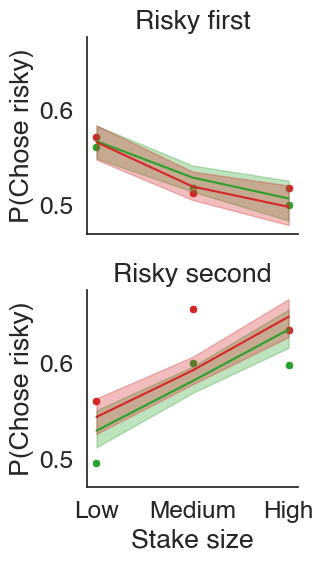

In [48]:
sns.set(font_scale=1.6, font='Helvetica', style='white')
groupby = ['stimulation_condition', 'risky_first', 'average_n_bin3']

summary = summarize_ppc(ppc.loc['p'].groupby(['subject'] + groupby).mean(), groupby=groupby)
p_behavior = df.groupby(['subject'] + groupby)['chose_risky'].mean().groupby(groupby).mean()

summary = summary.join(p_behavior)
summary['Order'] = summary.index.get_level_values('risky_first').map({True:'Risky first', False:'Risky second'})

g = sns.FacetGrid(summary.reset_index(), hue='stimulation_condition', aspect=1.2, palette=stimulation_palette, height=3, row='Order', sharey=True, row_order=['Risky first', 'Risky second'],
                  hue_order=['vertex', 'ips'])
g.map(sns.scatterplot, 'average_n_bin3', 'chose_risky', )
g.map(sns.lineplot, 'average_n_bin3', 'p_predicted', )

g.map(plt.fill_between, 'average_n_bin3', 'hdi025', 'hdi975', alpha=0.3)




g.set_titles('{row_name}')

g.set_axis_labels('Stake size', 'P(Chose risky)')

g.set(xticklabels=['Low', 'Medium', 'High'])

g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'ppc_11a_stakes.pdf'))

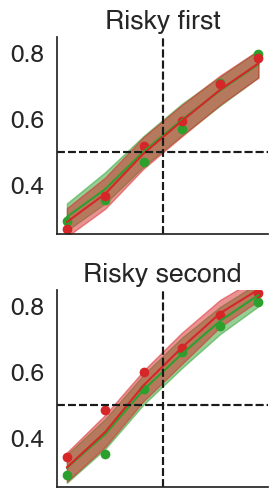

In [242]:
sns.set(style='white', font_scale=1.6, font='Helvetica')
g = plot_ppc(df, ppc, plot_type=11, level='group', legend=False,aspect=1.2, var_name='ll_bernoulli')

g.set_titles('{row_name}')

g.set(xticks=[], ylim=[.25, .85], ylabel=None, xlabel=None)


g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ppc11a_11.pdf'))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93764/3658721374.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = summarize_ppc(ppc.loc['p'].groupby(['subject'] + groupby).mean(), groupby=groupby)
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pred
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93764/3658721374.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

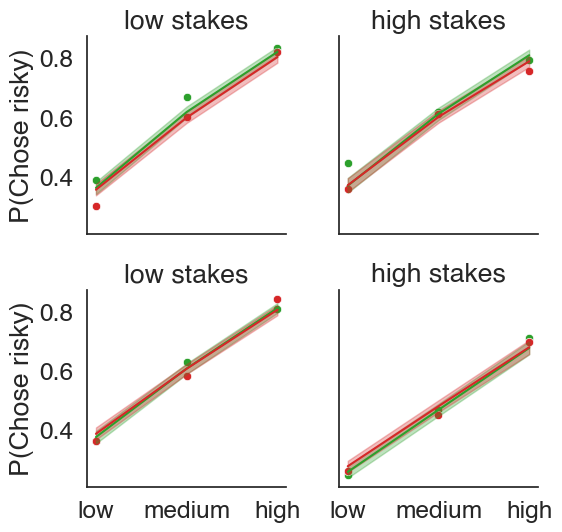

In [243]:

groupby = ['stimulation_condition', 'risky_first', 'average_n_bin2', 'bin3(risky/safe)']

summary = summarize_ppc(ppc.loc['p'].groupby(['subject'] + groupby).mean(), groupby=groupby)
p_behavior = df.groupby(['subject'] + groupby)['chose_risky'].mean().groupby(groupby).mean()

summary = summary.join(p_behavior)
summary['Order'] = summary.index.get_level_values('risky_first').map({True:'Risky first', False:'Risky second'})

g = sns.FacetGrid(summary.reset_index(), hue='stimulation_condition', aspect=1., palette=stimulation_palette, height=3, col='average_n_bin2', row='Order', sharey=True)
g.map(sns.scatterplot, 'bin3(risky/safe)', 'chose_risky', )
g.map(sns.lineplot, 'bin3(risky/safe)', 'p_predicted', )

g.map(plt.fill_between, 'bin3(risky/safe)', 'hdi025', 'hdi975', alpha=0.3)




g.set_titles('{col_name} stakes')

g.set_axis_labels('Risky/Safe ratio', 'P(Chose risky)')

g.set(xlabel=None)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93764/655353631.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = summarize_ppc(ppc.loc['p'].groupby(['subject'] + groupby).mean(), groupby=groupby)
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pred
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93764/655353631.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

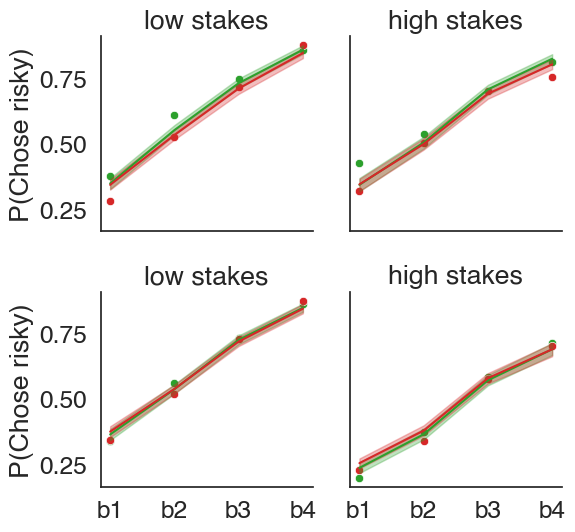

In [244]:

groupby = ['stimulation_condition', 'risky_first', 'average_n_bin2', 'bin4(risky/safe)']

summary = summarize_ppc(ppc.loc['p'].groupby(['subject'] + groupby).mean(), groupby=groupby)
p_behavior = df.groupby(['subject'] + groupby)['chose_risky'].mean().groupby(groupby).mean()

summary = summary.join(p_behavior)
summary['Order'] = summary.index.get_level_values('risky_first').map({True:'Risky first', False:'Risky second'})

g = sns.FacetGrid(summary.reset_index(), hue='stimulation_condition', aspect=1., palette=stimulation_palette, height=3, col='average_n_bin2', row='Order', sharey=True)
g.map(sns.scatterplot, 'bin4(risky/safe)', 'chose_risky', )
g.map(sns.lineplot, 'bin4(risky/safe)', 'p_predicted', )

g.map(plt.fill_between, 'bin4(risky/safe)', 'hdi025', 'hdi975', alpha=0.3)




g.set_titles('{col_name} stakes')

g.set_axis_labels('Risky/Safe ratio', 'P(Chose risky)')

g.set(xlabel=None)

In [ ]:
g = sns.FacetGrid(summary.reset_index(), hue='stimulation_condition', aspect=.8, palette=stimulation_palette, height=3, col='average_n_bin2', row='Order')

# Scatterplot for 'chose_risky'
g.map(sns.scatterplot, 'bin(risky/safe)', 'chose_risky')

# Pointplot for predicted probabilities with connecting lines disabled
def custom_pointplot(*args, **kwargs):
    sns.pointplot(*args, **kwargs, join=False, ci=None, marker='x')

g.map(sns.pointplot, 'bin(risky/safe)', 'p_predicted', marker='x', linestyle='none')

# Fill between HDI values
g.map(plt.fill_between, 'bin(risky/safe)', 'hdi025', 'hdi975', alpha=0.3)

# Titles, labels, and customizations
g.set_titles('{col_name} stakes')
g.set_axis_labels('Risky/Safe ratio', 'P(Chose risky)')
g.set(xticks=[])


/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


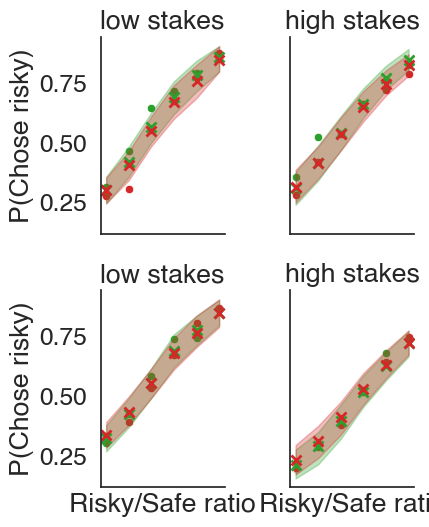

In [197]:
g = sns.FacetGrid(summary.reset_index(), hue='stimulation_condition', aspect=.8, palette=stimulation_palette, height=3, col='average_n_bin2', row='Order')

# Scatterplot for 'chose_risky'
g.map(sns.scatterplot, 'bin(risky/safe)', 'chose_risky')

# Pointplot for predicted probabilities with connecting lines disabled
def custom_pointplot(*args, **kwargs):
    sns.pointplot(*args, **kwargs, join=False, ci=None, marker='x')

g.map(sns.pointplot, 'bin(risky/safe)', 'p_predicted', marker='x', linestyle='none')

# Fill between HDI values
g.map(plt.fill_between, 'bin(risky/safe)', 'hdi025', 'hdi975', alpha=0.3)

# Titles, labels, and customizations
g.set_titles('{col_name} stakes')
g.set_axis_labels('Risky/Safe ratio', 'P(Chose risky)')
g.set(xticks=[])


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93764/3557604535.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = summarize_ppc(ppc.loc['ll_bernoulli'].groupby(['subject'] + groupby).mean(), groupby=groupby)
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pred
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_93764/3557604535.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

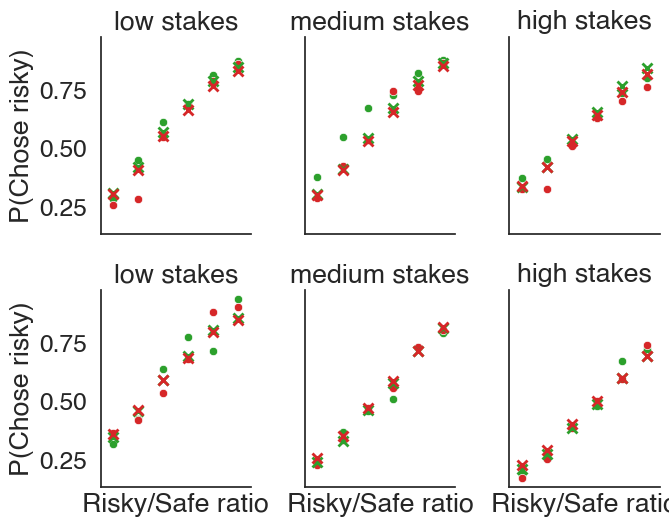

In [202]:

groupby = ['stimulation_condition', 'risky_first', 'average_n_bin3', 'bin(risky/safe)']

summary = summarize_ppc(ppc.loc['ll_bernoulli'].groupby(['subject'] + groupby).mean(), groupby=groupby)
p_behavior = df.groupby(['subject'] + groupby)['chose_risky'].mean().groupby(groupby).mean()

summary = summary.join(p_behavior)
summary['Order'] = summary.index.get_level_values('risky_first').map({True:'Risky first', False:'Risky second'})

g = sns.FacetGrid(summary.reset_index(), hue='stimulation_condition', aspect=.8, palette=stimulation_palette, height=3, col='average_n_bin3', row='Order')

# Scatterplot for 'chose_risky'
g.map(sns.scatterplot, 'bin(risky/safe)', 'chose_risky')

# Pointplot for predicted probabilities with connecting lines disabled
def custom_pointplot(*args, **kwargs):
    sns.pointplot(*args, **kwargs, join=False, ci=None, marker='x')

g.map(sns.pointplot, 'bin(risky/safe)', 'p_predicted', marker='x', linestyle='none')

# Fill between HDI values
# g.map(plt.fill_between, 'bin(risky/safe)', 'hdi025', 'hdi975', alpha=0.3)

# Titles, labels, and customizations
g.set_titles('{col_name} stakes')
g.set_axis_labels('Risky/Safe ratio', 'P(Chose risky)')
g.set(xticks=[])


/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


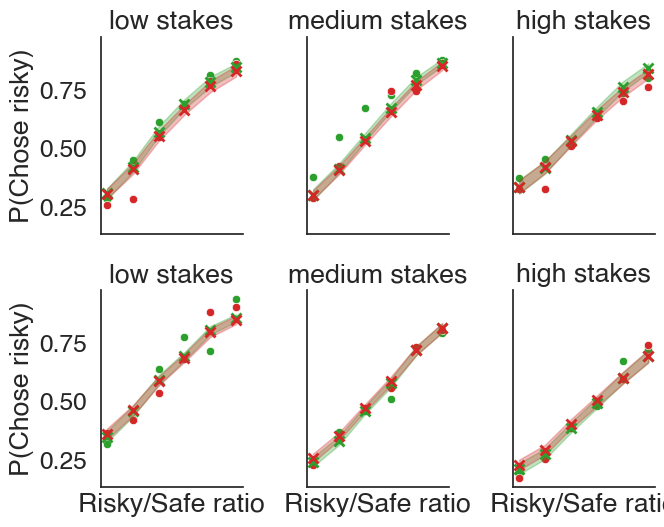

# SD as a function of n

In [79]:
model_label = 'flexible2'
conditions = pd.DataFrame([{'stimulation_condition':'vertex'},
                            {'stimulation_condition':'ips'}])

curve_stats = []
df, model, idata = get_info(model_label)
model.build_estimation_model()
curves = model.get_sd_curve(conditions, idata=idata, x=np.arange(7, 50), variable='both', group=True)
curve_stats = FlexibleNoiseRiskRegressionModel.get_sd_curve_stats(curves.stack().to_frame('value'), groupby=['stimulation_condition'])

In [80]:
def plot_prediction(data, x='x', y='value', **kwargs):
    ax = sns.lineplot(data=data, x=x, y=y, **kwargs)
    plt.fill_between(data[x], data['hdi025'], data['hdi975'], alpha=0.5, **kwargs)
    return ax

In [81]:
curve_stats['Variable'] = curve_stats.index.get_level_values('variable').map({'memory_noise_sd':'Memory noise (only option 1)', 'perceptual_noise_sd':'Perceptual noise (both options)'})

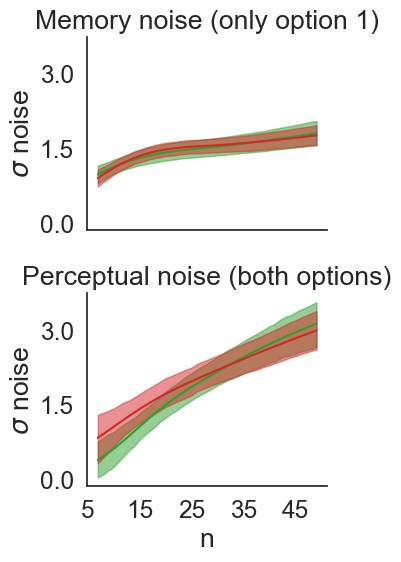

In [82]:
sns.set(font_scale=1.6, style='white')
g = sns.FacetGrid(curve_stats.reset_index(), row='Variable', hue='stimulation_condition', height=3., aspect=1.25, palette=stimulation_palette, 
                  hue_order=['vertex', 'ips'])

g.map_dataframe(plot_prediction)

g.set_titles('{row_name}')
g.set_ylabels('$\sigma$ noise')
g.set_xlabels('n')
g.set(xticks=np.arange(5, 50, 10), yticks=np.arange(0, 4.5, 1.5))
plt.tight_layout()
g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'sd_curves.pdf'))

In [83]:
# Calculate differneces:

diff = curves.stack().unstack('stimulation_condition').diff(axis=1).mean(axis=1).to_frame('difference TMS - vertex')
diff_stats = FlexibleNoiseRiskRegressionModel.get_sd_curve_stats(diff)
diff_stats['Variable'] = diff_stats.index.get_level_values('variable').map({'memory_noise_sd':'Memory noise (only option 1)', 'perceptual_noise_sd':'Perceptual noise (both options)'})

diff_stats['value'] = diff_stats['difference TMS - vertex']

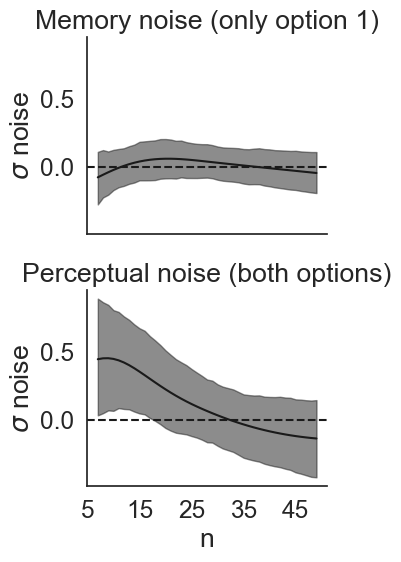

In [84]:
sns.set(font_scale=1.6, style='white')
g = sns.FacetGrid(diff_stats.reset_index(), row='Variable', height=3., aspect=1.25, palette=['gray'])

g.map_dataframe(plot_prediction, color='k')

g.set_titles('{row_name}')
g.set_ylabels('$\sigma$ noise')
g.set_xlabels('n')
g.set(xticks=np.arange(5, 50, 10))
g.map(plt.axhline, y=0, color='k', linestyle='--')

plt.tight_layout()

g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'sd_curves_diff.pdf'))